# Autoencoder

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import pickle
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

tf.disable_v2_behavior()

## Initialization

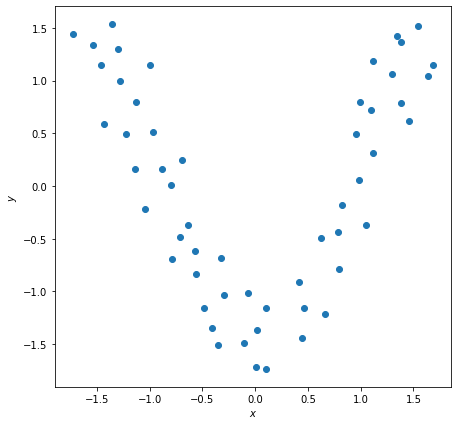

In [16]:
data = pickle.load(open('dataV.pickle', 'rb'))

plt.figure(figsize=(9, 7))
plt.scatter(data[:, 0], data[:, 1], label='Data')
plt.axis('scaled')
plt.xlabel('$x$')
plt.ylabel('$y$');

In [17]:
# Required for the contour lines
X, Y = np.mgrid[-2:2:100j, -2:2:100j]
data_grid = np.asarray([X.ravel(), Y.ravel()]).transpose()

# Reproducible results with TensorFlow
def reset():
    tf.reset_default_graph()
    tf.set_random_seed(1337)
    np.random.seed(1337)

## Part 1: Linear autoencoder

In [18]:
# Reset the graph before each run to get reproducible results
reset()

# Dimensions of our network
n_inputs = 2
n_hidden = 1
n_outputs = n_inputs  # In case of autoencoders (AEs), the output dimension must be the same as the input dimension

# This creates a node in the graph which can later be fed with an input
# [batch, input]: the batch dimension is set implicitly and specified later in the execution phase
input = tf.placeholder(tf.float64, shape=[None, n_inputs])

# The bottleneck layer contains the PCA codings (projections)
coding = tf.layers.dense(input, units=n_hidden)  # Creates a normal neural network layer

# The output layer produces (ideally) the input again
outputs = tf.layers.dense(coding, units=n_outputs)

# The MSE is our error function
loss = tf.reduce_mean(tf.square(outputs - input))

# Define the optimizer to use (Adam is a more advanced optimizer than SGD)
optimizer = tf.train.AdamOptimizer(learning_rate=0.05)

# Tells the optimizer that we want to minimize our error function
# It returns an operation node which we must later execute to apply one step of the optimizer
train = optimizer.minimize(loss)

# We have now completed our construction phase and are about to enter the execution phase. The latter is defined by a
# session object. You allways need a session to actually perform operations. The state of every variable is connected to
# the current session. The lifetime of the variables end when the session closes, e.g. after the with block in the following
# (which automatically closes the session)
with tf.Session() as sess:
    # This is the first time the variables get actually initialized
    tf.global_variables_initializer().run()

    # Repeat our training operation for multiple epochs
    epochs = 5000
    for epoch in range(epochs):
        # With the feed_dict argument, you must specify the values for all the defined placeholders in the graph (in this
        # case, we have only one - the input)
        train.run(feed_dict={input: data})
    
    # After the training finished, we can extract information from our network nodes
    proj_linear, predictions_linear, error_linear = sess.run([coding, outputs, loss], feed_dict={input: data})
    proj_grid_linear = coding.eval(feed_dict={input: data_grid}).reshape(X.shape)
    
    # Note: whenever it is possible, use sess.run() instead of node.eval(). With the former, you can compute the values for
    #       multiple nodes at once. This facilitates the re-use of already computed nodes (otherwise, the values of all
    #       dependent nodes are re-calculated)

error_linear

0.4888161868281835

### PCA

In [19]:
pca = PCA(n_components=1)
pca.fit(data)
u_1 = pca.components_[0]
print("u_1 = %s" % str(u_1))

u_1 = [0.70710678 0.70710678]


### Plot

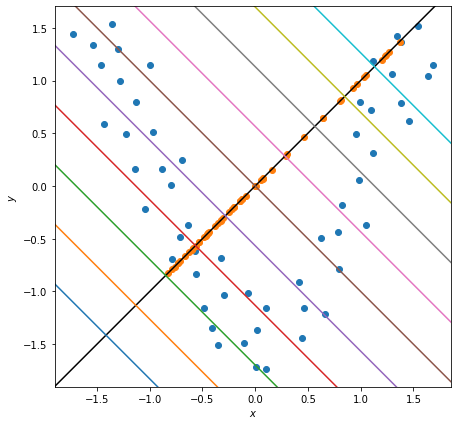

In [20]:
plt.figure(figsize=(9, 7))
plt.scatter(data[:, 0], data[:, 1], label='Data')
plt.axis('scaled')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.plot([-u_1[0]*3, u_1[0]*3], [-u_1[1]*3, u_1[1]*3], color="black", label="PCA line")
plt.scatter(u_1[0] * proj_linear, u_1[1] * proj_linear, label="AE Output")

proj_min = np.min(proj_linear)
proj_max = np.max(proj_linear)
u_1_vert = [-u_1[1] * 3, u_1[0] * 3]
for c in range(10):
    scale = (c/10 - 0.5) * 4
    anchor = u_1 * scale
    pt0 = anchor - u_1_vert 
    pt1 = anchor + u_1_vert
    plt.plot([pt0[0], pt1[0]], [pt0[1], pt1[1]])
    


## Part 2: Non-linear autoencoder

Epoch: 0	Loss :2.063534
Epoch: 500	Loss :0.234658
Epoch: 1000	Loss :0.175118
Epoch: 1500	Loss :0.166350
Epoch: 2000	Loss :0.163863
Epoch: 2500	Loss :0.162393
Epoch: 3000	Loss :0.161047
Epoch: 3500	Loss :0.161063
Epoch: 4000	Loss :0.160889
Epoch: 4500	Loss :0.160764
Epoch: 5000	Loss :0.160937
Epoch: 5500	Loss :0.160676
Epoch: 6000	Loss :0.159721
Epoch: 6500	Loss :0.160052
Epoch: 7000	Loss :0.160608
Epoch: 7500	Loss :0.159380
Epoch: 8000	Loss :0.159878
Epoch: 8500	Loss :0.159350
Epoch: 9000	Loss :0.158937
Epoch: 9500	Loss :0.159179
Epoch: 10000	Loss :0.157136
Epoch: 10500	Loss :0.157225
Epoch: 11000	Loss :0.157128
Epoch: 11500	Loss :0.157144
Epoch: 12000	Loss :0.157261
Epoch: 12500	Loss :0.157259
Epoch: 13000	Loss :0.157579
Epoch: 13500	Loss :0.157147
Epoch: 14000	Loss :0.157686
Epoch: 14500	Loss :0.157261
Epoch: 15000	Loss :0.157324
Epoch: 15500	Loss :0.157294
Epoch: 16000	Loss :0.157332
Epoch: 16500	Loss :0.158016
Epoch: 17000	Loss :0.157769
Epoch: 17500	Loss :0.157200
Epoch: 18000	Los

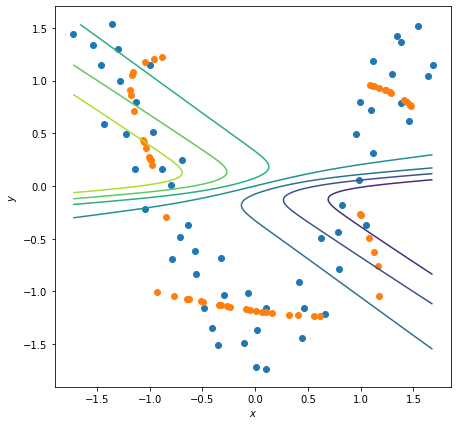

In [21]:
reset()

n_neurons = 20
n_inp = data.shape[1]
n_out = n_inp
n_latent = 1
reg_lambda = 0.002

inp = tf.placeholder(shape=(None, n_inp), dtype=tf.float32)
out = tf.placeholder(shape=(None, n_out), dtype=tf.float32)

enc_w_1 = tf.Variable(tf.random_normal([n_inp, n_neurons]))
enc_w_2 = tf.Variable(tf.random_normal([n_neurons, n_latent]))
dec_w_1 = tf.Variable(tf.random_normal([n_latent, n_neurons]))
dec_w_2 = tf.Variable(tf.random_normal([n_neurons, n_out]))

enc = tf.nn.tanh(tf.matmul(inp, enc_w_1))
latent = tf.matmul(enc, enc_w_2)
dec = tf.nn.tanh(tf.matmul(latent, dec_w_1))
logits = tf.matmul(dec, dec_w_2)

mse_loss = tf.reduce_mean(tf.losses.mean_squared_error(logits, out))
reg = tf.reduce_sum(tf.abs(enc_w_1)) + \
    tf.reduce_sum(tf.abs(enc_w_2)) + \
    tf.reduce_sum(tf.abs(dec_w_1)) + \
    tf.reduce_sum(tf.abs(dec_w_2))

loss = mse_loss + reg_lambda * reg

# Training arguments are chosen experimentally
optimizer = tf.train.AdamOptimizer(learning_rate=0.05).minimize(loss)

max_x = np.max(data[:, 0])
min_x = np.min(data[:, 0])
max_y = np.max(data[:, 1])
min_y = np.min(data[:, 1])
x, y = np.meshgrid(np.arange(min_x, max_x, 0.001), np.arange(min_y, max_y, 0.001))
in_points = np.stack((np.ndarray.flatten(x), np.ndarray.flatten(y)), axis=-1)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for c in range(5000):
        _, loss_val = sess.run([optimizer, loss], feed_dict={
            inp: data,
            out: data
        })
        
        if c % 500 == 0:
            print("Epoch: %d\tLoss :%f" % (c, loss_val))
        
        
    ae_output = sess.run(logits, feed_dict={
        inp: data
    })
    
    output_for_lines = sess.run(latent, feed_dict={
        inp: in_points
    })
    
res_surface = np.reshape(output_for_lines, x.shape)
plt.figure(figsize=(9, 7))
plt.scatter(data[:, 0], data[:, 1], label='Data')
plt.axis('scaled')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.scatter(ae_output[:, 0], ae_output[:, 1], label="AE Output")
plt.contour(x, y, res_surface)
plt.show()